In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import matplotlib.pyplot as plt

class ShipPerformanceModel:
    """
    Models a ship's performance based on sensor and weather data.
    Can load data, train a model, and make predictions.
    """

    def __init__(self, vessel, start_date, end_date):
        """
        Initializes the ShipPerformanceModel.

        Args:
            vessel (str): Name of the vessel.
            start_date (str or datetime.date): Start date in YYYY-MM-DD format.
            end_date (str or datetime.date): End date in YYYY-MM-DD format.
        """
        self.vessel = vessel
        self.start_date = start_date
        self.end_date = end_date

    def _csv_path(self, type_="sensor"):
        """
        Generates the CSV file path for sensor or weather data.

        Args:
            type_ (str, optional): Type of data ('sensor' or 'weather'). Defaults to 'sensor'.

        Returns:
            str: The generated file path.
        """
        data_dir = os.path.join(os.getcwd(), "data")
        file_name = f"{self.vessel.lower()}_{type_.lower()}.csv"
        return os.path.join(data_dir, file_name)

    def _date_filter(self, df):
        """
        Filters a DataFrame based on the start and end dates.

        Args:
            df (pd.DataFrame): DataFrame with a 'date_and_time' column.

        Returns:
            pd.DataFrame: The filtered DataFrame.
        """
        df["date_and_time"] = pd.to_datetime(df["date_and_time"], format="%d-%m-%y %H:%M")
        mask = (df["date_and_time"] >= self.start_date) & (df["date_and_time"] <= self.end_date)
        return df[mask].copy()  

    def load_sensor_data(self):
        """
        Loads and filters sensor data.

        Returns:
            pd.DataFrame: The filtered sensor data.
        """
        df = pd.read_csv(self._csv_path("sensor"))
        df = df.astype(float, errors='ignore')  # Convert columns to numeric types
        return self._date_filter(df)

    def load_weather_data(self):
        """
        Loads and filters weather data.

        Returns:
            pd.DataFrame: The filtered weather data.
        """
        df = pd.read_csv(self._csv_path("weather"))
        df = df.astype(float, errors='ignore')
        return self._date_filter(df)

    def combine_data(self):
        """
        Combines sensor and weather data.

        Returns:
            pd.DataFrame: The combined DataFrame.
        """
        sensors = self.load_sensor_data()
        weather = self.load_weather_data()
        return sensors.merge(weather, on="date_and_time")

    def add_attributes(self, data):
        """
        Calculates additional attributes (wind speed and angle).

        Args:
            data (pd.DataFrame): DataFrame containing 'wind_u' and 'wind_v'.

        Returns:
            pd.DataFrame: DataFrame with the added attributes.
        """
        # wind_speed = (wind_u^2 + wind_v^2)^0.5
        data['wind_speed'] = np.hypot(data['wind_u'], data['wind_v'])
        # wind_angle = arctan(wind_v/wind_u)
        # (0 means going E pi/2 N, …)
        data['wind_angle'] = np.arctan2(data['wind_v'], data['wind_u'])
        return data

    def preprocess_data(self, data):
        """
        Preprocesses the data for modeling.

        Args:
            data (pd.DataFrame): The combined DataFrame.

        Returns:
            tuple: (X, y), where X is the feature matrix and y is the target variable.
        """
        # Remove any measurements during which the ship is not in normal operating conditions at sea
        data = data[(data['gps_speed']!=0) & (data['power']!=0) & (data['consumption']!=0)]
        # Remove rows with missing values
        data = data.dropna()

        # Select features and target
        X = data[['gps_speed', 'course', 'wind_u', 'wind_v', 'wind_speed', 'wind_angle']]
        y = data[['consumption']]  # Target is fuel consumption

        return X, y

    def speed_categorization(self, X, n_levels=7):
        """
        Categorizes GPS speed into discrete levels.

        Args:
            X (pd.DataFrame): Data containing 'gps_speed' column.
            n_levels (int, optional): Number of speed levels. Defaults to 7.

        Returns:
            pd.Series: Categorical representation of GPS speed.
        """
        return pd.cut(X['gps_speed'], bins=n_levels, labels=range(n_levels))

    def stratified_train_test_split(self, X, y, test_size=0.2, random_state=42):
        """
        Performs stratified splitting based on GPS speed for representative sampling.

        Args:
            X (pd.DataFrame): Feature matrix.
            y (pd.DataFrame or pd.Series): Target variable.
            test_size (float, optional): Proportion of data for the test set. Defaults to 0.2.
            random_state (int, optional): Random seed. Defaults to 42.

        Returns:
            tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
        """
        X['speed_level'] = self.speed_categorization(X)  # Create speed categories

        # Split into train and temp set (stratified by 'speed_level')
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=X['speed_level']
        )

        # Split temp into val and test sets (stratified)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=random_state, stratify=X_temp['speed_level']
        )

        # Drop the temporary 'speed_level' column
        return (
            X_train.drop('speed_level', axis=1),
            X_val.drop('speed_level', axis=1),
            X_test.drop('speed_level', axis=1),
            y_train, y_val, y_test
         )

    def create_train_test_sets(self, test_size=0.3, random_state=42):
        """
        Loads, combines, preprocesses data, and creates train/val/test sets.

        Args:
            test_size (float, optional): Proportion of data for test. Defaults to 0.3.
            random_state (int, optional): Random seed. Defaults to 42.

        Returns:
             tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
        """
        data = self.combine_data()
        data = self.add_attributes(data)
        X, y = self.preprocess_data(data)
        return self.stratified_train_test_split(X, y, test_size, random_state)

    def train_model(self, X_train, y_train):
        """
        Trains an XGBoost regression model.

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series): Training target.

        Returns:
            xgb.XGBRegressor: Trained model.
        """
        model = xgb.XGBRegressor(objective ='reg:squarederror')
        model.fit(X_train, y_train)
        return model

    def test_model(self, model, X_test, y_test):
        """
        Calculates MAPE (Mean Absolute Percentage Error) on the test set.

        Args:
            model: Trained model.
            X_test (pd.DataFrame): Test features.
            y_test (pd.Series): Test target values.

        Returns:
            float: MAPE value.
        """
        y_pred = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100 
        return mape

    def print_metrics(self, mape):
        """Prints the MAPE metric."""
        print(f'{mape.round(2)}%')

In [11]:
class PerformancePredictor:
    """Predicts ship performance using a trained model."""

    def __init__(self, model):
        """ Initializes the predictor with a trained model. """
        self.model = model

    def predict_from_csv(self, csv_file_path):
        """
        Predicts fuel consumption from a CSV file containing input parameters.

        Args:
            csv_file_path (str): Path to the CSV file.

        Returns:
            np.ndarray: Array of predicted fuel consumption values.
        """
        data = pd.read_csv(csv_file_path)

        # Calculate wind_u and wind_v from wind speed and angle
        data['wind_u'] = np.cos(data['wind_angle']) * data['wind_speed']
        data['wind_v'] = np.sin(data['wind_angle']) * data['wind_speed']

        # Select features used by the model
        X = data[['gps_speed', 'course', 'wind_u', 'wind_v', 'wind_speed', 'wind_angle']].values
        
        return self.model.predict(X)


In [12]:
# Function for plotting the fuel consumption vs. speed curve
def plot_fuel_speed_curve(parameters, consumption_prediction):
    
    # Fit a polynomial
    gps_speed = parameters['gps_speed'].values
    p = np.poly1d(np.polyfit(gps_speed, consumption_prediction, 2))
    
    # Create subplots
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot original data
    ax.scatter(gps_speed, consumption_prediction, color='blue', label='Predicted Consumption')
    
    # Plot polynomial fit
    gps_speed_sorted = np.linspace(min(gps_speed), max(gps_speed), 100)
    ax.plot(gps_speed_sorted, p(gps_speed_sorted), color='red', linewidth=5, label='Polynomial Fit')
    
    ax.set_xlabel('GPS Speed [kts]')
    ax.set_ylabel('Predicted Consumption [mt/day]')
    ax.set_title("Predicted Consumption vs. GPS Speed\n" \
                 "{}={} rad  {}={} m/s  {}={} rad".format( 
                    parameters.columns[1], parameters.iloc[0, 1],
                    parameters.columns[2], parameters.iloc[0, 2],
                    parameters.columns[3], parameters.iloc[0, 3]
                ))
    ax.legend()
    ax.grid(True)

    fig.savefig('FuelSpeedCurve.png')
    
    plt.show()

In [13]:
# Create a ShipPerformanceModel instance
spm = ShipPerformanceModel(vessel='Celine', start_date='2022-01-01', end_date='2022-10-01')

# Split data into training, validation, and testing sets
X_train, X_val, X_test, y_train, y_val, y_test = spm.create_train_test_sets()

# Train the model
model = spm.train_model(X_train, y_train)

In [14]:
# Evaluate on validation and test sets
mape_val = spm.test_model(model, X_val, y_val)
print('Validation MAPE:')
spm.print_metrics(mape_val)

Validation MAPE:
14.66%


In [15]:
mape_test = spm.test_model(model, X_test, y_test)
print('Test MAPE:')
spm.print_metrics(mape_test)

Test MAPE:
15.28%


In [16]:
# Save the model
model.save_model('spm.bin')

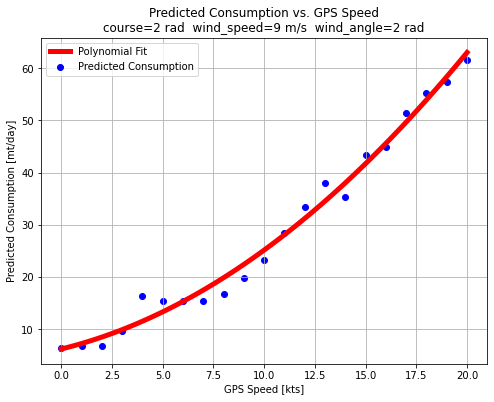

In [17]:
# Load the model and create a predictor
predictor = PerformancePredictor(model)

# Predict consumption from a CSV file of input parameters
predictions = predictor.predict_from_csv('input_parameters.csv')

# Plot the fuel consumption vs. speed curve
input_parameters = pd.read_csv('input_parameters.csv')
plot_fuel_speed_curve(input_parameters, predictions)